In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Describing Songs Dataset

In [5]:
msd = pd.read_csv('msd_summary.csv')
msd.shape

(1000000, 54)

In [6]:
msd.describe()

,Unnamed: 0,analysis_sample_rate,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,artist_longitude,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release_7digitalid,song_hotttnesss,track_7digitalid,idx_artist_mbtags,year
count,1000000.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,357492.000000,1000000.000000,0.0,1000000.0,1000000.0,1000000.000000,581965.000000,1.000000e+06,1000000.0,1000000.000000
mean,499999.500000,22050.0,0.0,249.500755,0.819850,0.0,0.0,0.0,0.0,0.0,...,-58.370804,26302.206937,NaN,0.0,0.0,379884.834575,0.356051,4.213995e+06,0.0,1030.325652
std,288675.278933,0.0,0.0,126.229636,3.304457,0.0,0.0,0.0,0.0,0.0,...,54.955555,47052.147503,NaN,0.0,0.0,237443.651689,0.234441,2.640600e+06,0.0,998.745002
min,0.000000,22050.0,0.0,0.313020,0.000000,0.0,0.0,0.0,0.0,0.0,...,-162.436500,-1.000000,NaN,0.0,0.0,-1.000000,0.000000,-1.000000e+00,0.0,0.000000
25%,249999.750000,22050.0,0.0,180.740770,0.000000,0.0,0.0,0.0,0.0,0.0,...,-91.523820,-1.000000,NaN,0.0,0.0,179685.000000,0.215080,1.974300e+06,0.0,0.000000
50%,499999.500000,22050.0,0.0,228.858320,0.194000,0.0,0.0,0.0,0.0,0.0,...,-77.366920,48.000000,NaN,0.0,0.0,350853.000000,0.377532,3.947503e+06,0.0,1969.000000
75%,749999.250000,22050.0,0.0,289.932610,0.432000,0.0,0.0,0.0,0.0,0.0,...,-2.232180,33964.000000,NaN,0.0,0.0,582854.750000,0.531985,6.469678e+06,0.0,2002.000000
max,999999.000000,22050.0,0.0,3034.905670,1163.941000,0.0,0.0,0.0,0.0,0.0,...,178.690960,242965.000000,NaN,0.0,0.0,823654.000000,1.000000,9.091277e+06,0.0,2011.000000


In [7]:
#Most Popular Songs
msd.sort_values(by=['song_hotttnesss','year'],ascending=False)[['title','artist_name','release','song_hotttnesss','year']].head(10)

,title,artist_name,release,song_hotttnesss,year
69427,If We Ever Meet Again,Timbaland / Katy Perry,If We Ever Meet Again (Featuring Katy Perry),1.0,2010
78108,Alice,Avril Lavigne,Almost Alice,1.0,2010
85836,Cooler Than Me,Mike Posner,Cooler Than Me,1.0,2010
196742,Somebody To Love,Justin Bieber,My Worlds,1.0,2010
332746,Holiday,Vampire Weekend,Contra,1.0,2010
424919,Nothin' On You [feat. Bruno Mars] (Album Version),B.o.B,B.o.B Presents: The Adventures of Bobby Ray,1.0,2010
711682,Somebody To Love,Justin Bieber,My World 2.0,1.0,2010
712993,Odessa,Caribou,Odessa,1.0,2010
746866,Alice,Avril Lavigne,Alice,1.0,2010
828866,Tighten Up,The Black Keys,Tighten Up,1.0,2010


# Data Preprocessing & Descriptive Analysis

In [8]:
# Data Preprocessing

print('Variables with zero variance: ')
print(msd.std()[msd.std() == 0].index)

# Drops variables with 0 variance
msd = msd.drop(msd.std()[msd.std() == 0].index, axis = 1) 

# Gives the categorical variables minus the target variable in our dataset
categorical_var = list(msd.dtypes[msd.dtypes == object].index)

# Creates an empty list for categorical variables with zero variation
zero_cardinality = [] 

for i in categorical_var: 
    if len(msd[i].value_counts().index) == 1: 
        zero_cardinality.append(i) 

print('Variables with zero cardinality: ')
print(zero_cardinality)
msd = msd.drop(zero_cardinality, axis = 1) # Drops variables with 0 variance

# Gives the categorical variables minus the target variable in our dataset
categorical_var = list(msd.dtypes[msd.dtypes == object].index)

# Creates a list of categorical variables with high cardinality
high_cardinality = [] 

for i in categorical_var: 
    if len(msd[i].value_counts().index) > 200: # check how many levels it has and if it is more than 200, variable
        high_cardinality.append(i) # has many levels so append it to the list of categorical variables with high cardinality
         
print('Variables with high cardinality: ')
print(high_cardinality)
msd = msd.drop(high_cardinality, axis = 1) # Drops variables with high cardinality

#Drops 1st id column
del msd['Unnamed: 0']

Variables with zero variance: 
Index(['analysis_sample_rate', 'danceability', 'energy', 'idx_bars_confidence',
       'idx_bars_start', 'idx_beats_confidence', 'idx_beats_start',
       'idx_sections_confidence', 'idx_sections_start',
       'idx_segments_confidence', 'idx_segments_loudness_max',
       'idx_segments_loudness_max_time', 'idx_segments_loudness_start',
       'idx_segments_pitches', 'idx_segments_start', 'idx_segments_timbre',
       'idx_tatums_confidence', 'idx_tatums_start', 'idx_artist_terms',
       'idx_similar_artists', 'idx_artist_mbtags'],
      dtype='object')
Variables with zero cardinality: 
[]
Variables with high cardinality: 
['audio_md5', 'track_id', 'artist_id', 'artist_location', 'artist_mbid', 'artist_name', 'release', 'song_id', 'title']


In [9]:
#checking for missing values
{i:sum(msd[i].isnull()) for i in msd.columns}

{'duration': 0,
 'end_of_fade_in': 0,
 'key': 0,
 'key_confidence': 0,
 'loudness': 0,
 'mode': 0,
 'mode_confidence': 0,
 'start_of_fade_out': 0,
 'tempo': 0,
 'time_signature': 0,
 'time_signature_confidence': 0,
 'analyzer_version': 1000000,
 'artist_7digitalid': 0,
 'artist_familiarity': 185,
 'artist_hotttnesss': 12,
 'artist_latitude': 642508,
 'artist_longitude': 642508,
 'artist_playmeid': 0,
 'genre': 1000000,
 'release_7digitalid': 0,
 'song_hotttnesss': 418035,
 'track_7digitalid': 0,
 'year': 0}

In [10]:
#Dropping the variables which has more than 50% of missing data
msd.drop(['analyzer_version', 'artist_latitude', 'artist_longitude', 'genre'], axis=1, inplace=True)

# Removes rows where year =0
msd = msd.drop(msd[msd.year == 0].index)

# Removes rows where the song_hotttnesss = 0 or null
msd = msd.dropna(axis=0, subset=['song_hotttnesss'])
msd = msd.drop(msd[msd.song_hotttnesss==0].index)

# Dropping id variables and variables which are not significant to song popularity
msd.drop(['artist_7digitalid','artist_playmeid','track_7digitalid','release_7digitalid','key_confidence','mode_confidence','time_signature_confidence'], axis=1, inplace=True)


msd.shape

(306298, 12)

In [11]:
# Again checking for missing values
msd = msd.dropna(axis=0, subset=['artist_familiarity'])

print(msd.shape)

# variables let after preprocessing
print(msd.columns)

msd.describe()

(306297, 12)
Index(['duration', 'end_of_fade_in', 'key', 'loudness', 'mode',
       'start_of_fade_out', 'tempo', 'time_signature', 'artist_familiarity',
       'artist_hotttnesss', 'song_hotttnesss', 'year'],
      dtype='object')


,duration,end_of_fade_in,key,loudness,mode,start_of_fade_out,tempo,time_signature,artist_familiarity,artist_hotttnesss,song_hotttnesss,year
count,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000,306297.000000
mean,245.989748,0.876209,5.313669,-9.289045,0.659781,236.675931,125.457857,3.636983,0.618609,0.430781,0.487167,1999.742329
std,110.965225,2.833751,3.594276,4.789618,0.473783,108.672704,34.916495,1.180531,0.114849,0.095559,0.156768,9.722472
min,0.678730,0.000000,0.000000,-52.559000,0.000000,0.679000,0.000000,0.000000,0.000000,0.000000,0.187701,1922.000000
25%,185.991380,0.000000,2.000000,-11.636000,0.000000,177.946000,99.262000,4.000000,0.546981,0.376689,0.372530,1996.000000
50%,231.078730,0.194000,5.000000,-8.198000,1.000000,221.553000,122.631000,4.000000,0.614654,0.421589,0.485531,2003.000000
75%,284.551380,0.428000,9.000000,-5.852000,1.000000,273.874000,146.489000,4.000000,0.691134,0.480575,0.597641,2007.000000
max,3007.738320,358.214000,11.000000,3.966000,1.000000,3007.738000,280.955000,7.000000,1.000000,1.082503,1.000000,2011.000000


In [12]:
#Creating target variable 'isPopular' using variable 'song_hotttnesss'
song_hotness_mean = msd.song_hotttnesss.mean()#0.487166
threshold = song_hotness_mean
msd['isPopular'] = 0
msd = msd.set_value(msd[msd.song_hotttnesss>threshold].index,'isPopular',1)

# Data Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021162034E48>]],
      dtype=object)

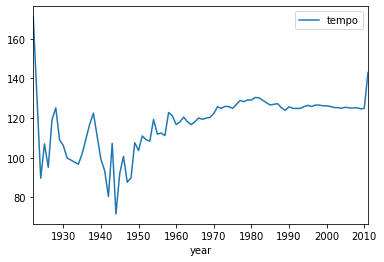

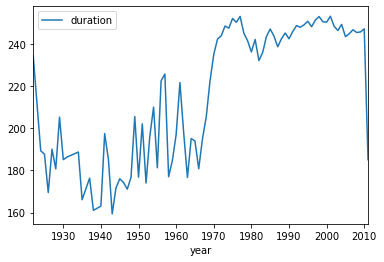

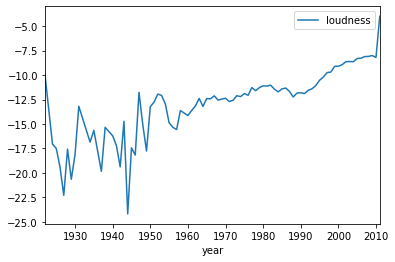

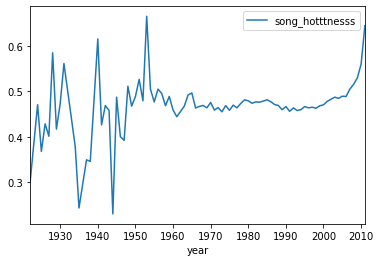

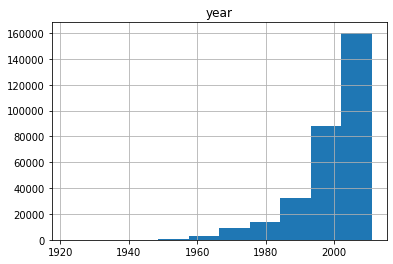

In [13]:
# Data trends over the years
years_compare = msd.groupby(msd.year).mean().reset_index()
years_compare.plot(x='year',y='tempo')

years_compare.plot(x='year',y='duration')

years_compare.plot(x='year',y='loudness')

years_compare.plot(x='year',y='song_hotttnesss')

#Number of songs over the years
bins = range(1920,2020,10)
msd.hist(column='year',bins = 10)

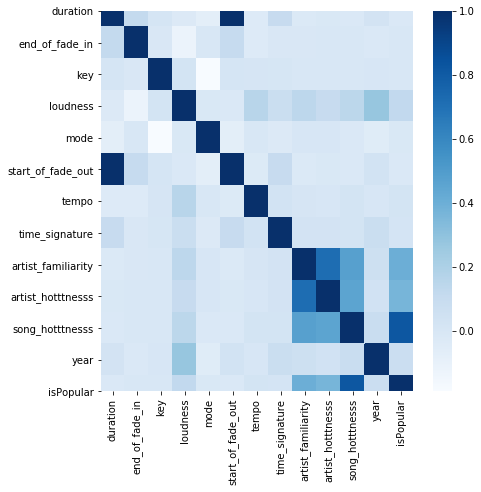

In [16]:
#Correlation
correlation = msd.corr()
plt.figure(figsize = (7,7))
sns.heatmap(correlation, cmap="Blues")

In [17]:
# Droppin 'year' since its not important to predict the song popularity
msd = msd.drop(['year'],axis=1)

# Feature Selection

[0.09459846 0.08976072 0.06828294 0.10858164 0.0043032  0.09509261
 0.09815628 0.03168399 0.2190277  0.19051245]


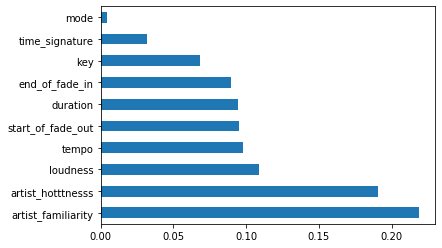

In [18]:
#Feature selection
X = msd.drop(['song_hotttnesss','isPopular'],axis=1)
X = X.select_dtypes(exclude=[object])
Y = msd['isPopular'].values

model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [19]:
#Verifying the variables we selected 
rfe_selector = RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X, Y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
rfe_feature

['duration',
 'end_of_fade_in',
 'key',
 'loudness',
 'mode',
 'start_of_fade_out',
 'tempo',
 'time_signature',
 'artist_familiarity',
 'artist_hotttnesss']

In [20]:
# From above variable selection, dropping 'mode', 'time_signature', 'key'.  
# Splitting the data
X = msd.drop(['mode', 'time_signature', 'key','song_hotttnesss', 'isPopular'], axis = 1)
y = msd['isPopular']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.80)

# Fitting Models

In [22]:
#Logistic Regression

lr = LogisticRegression(random_state=0, max_iter=200)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.696669931439765

In [23]:
#svc

svc = LinearSVC(random_state=0, tol=1e-5, max_iter=5000)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [24]:
#Decision Tree
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

In [25]:
#Random Forest
rforest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rforest.fit(X_train, y_train)
rforest_pred = rforest.predict(X_test)

In [26]:
#Naive Bayes
naive = GaussianNB()
naive.fit(X_train, y_train)  
naive_pred = naive.predict(X_test)

In [27]:
#Artificial Neural Network

ann = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=200)   
ann.fit(X_train, y_train)
ann_pred = ann.predict(X_test)

In [28]:
#Function to calculate accuracy and cross validation score
def detailed_stats(X_test, y_train, y_test, y_pred, clf):
    
    scores = cross_val_score(clf, X_test, y_test, cv=5)
    score = np.mean(scores)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp/(fp+tn)
    precision = tp / (tp + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    fmeasure = (2*precision*sensitivity) /(precision+sensitivity)
    return [score, accuracy, sensitivity, specificity, fpr, precision, fmeasure]

# Performance Summary & Model Selection

In [29]:
#Model selection
models_list = [lr, svc, dtree, rforest, naive, ann]
index = ['Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'Artificial Neural Network']
prediction_list = [lr_pred, svc_pred, dtree_pred, rforest_pred, naive_pred, ann_pred]
performance = pd.DataFrame(columns = ['CV_Score', 'Accuracy', 'Sensitivity','Specificity', 'fpr', 'Precision', 'FMeasure'])
for id, model in enumerate(models_list):
    performance.loc[index[id]] = detailed_stats(X_test, y_train, y_test, prediction_list[id], model)
performance

,CV_Score,Accuracy,Sensitivity,Specificity,fpr,Precision,FMeasure
Logistic Regression,0.696588,0.696670,0.665074,0.727670,0.272330,0.705539,0.684709
SVC,0.550669,0.528567,0.058244,0.990007,0.009993,0.851156,0.109027
Decision Tree,0.640271,0.705322,0.701628,0.708945,0.291055,0.702833,0.702230
Random Forest,0.696392,0.693275,0.712110,0.674795,0.325205,0.682375,0.696926
Naive Bayes,0.672315,0.691152,0.698299,0.684141,0.315859,0.684447,0.691304
Artificial Neural Network,0.559909,0.561770,0.445646,0.675700,0.324300,0.574146,0.501800


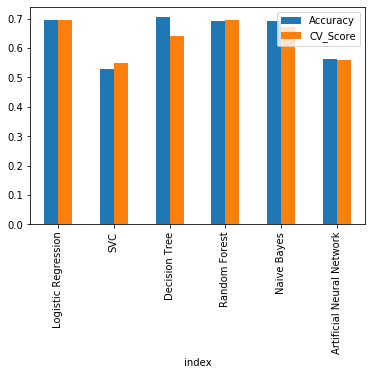

In [30]:
# Accuracy and Cross validation score Graph
performance.reset_index().plot(x='index' ,y=['Accuracy', 'CV_Score'],kind='bar')

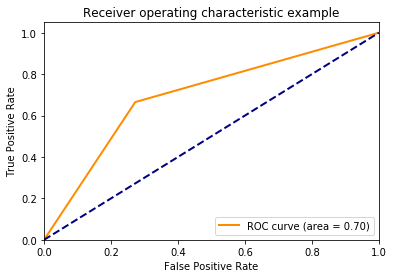

In [33]:
#Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test, lr_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [34]:
#Function to calculate accuracy from 
def get_accuracy(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp/(fp+tn)
    precision = tp / (tp + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    fmeasure = (2*precision*sensitivity) /(precision+sensitivity)
    return [accuracy, sensitivity, specificity, fpr, precision, fmeasure]

In [35]:
#Accuracy at various threshold from 0.4 to 0.7
accuracy = pd.DataFrame(columns = ['Accuracy', 'Sensitivity','Specificity', 'fpr', 'Precision', 'FMeasure'])
for i in np.arange(0.4, 0.7, 0.01):
    lr_pred = (lr.predict_proba(X_test)[:, 1] > i).astype(int)
    accuracy.loc[i] = get_accuracy(y_test, lr_pred)
accuracy

,Accuracy,Sensitivity,Specificity,fpr,Precision,FMeasure
0.40,0.683088,0.824906,0.543949,0.456051,0.639593,0.720525
0.41,0.687463,0.812908,0.564388,0.435612,0.646753,0.720374
0.42,0.689553,0.797350,0.583791,0.416209,0.652725,0.717825
0.43,0.692687,0.783275,0.603810,0.396190,0.659827,0.716271
0.44,0.694564,0.767684,0.622825,0.377175,0.666323,0.713421
0.45,0.695935,0.751434,0.641485,0.358515,0.672815,0.709955
0.46,0.696817,0.733997,0.660339,0.339661,0.679503,0.705700
0.47,0.698221,0.717549,0.679257,0.320743,0.687001,0.701943
0.48,0.697894,0.700771,0.695071,0.304929,0.692756,0.696741
0.49,0.697078,0.683071,0.710821,0.289179,0.698567,0.690732
